In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from scipy.interpolate import interpn

# Phase 1: Visualize the difference between Standard and Natural Gradient Descent.

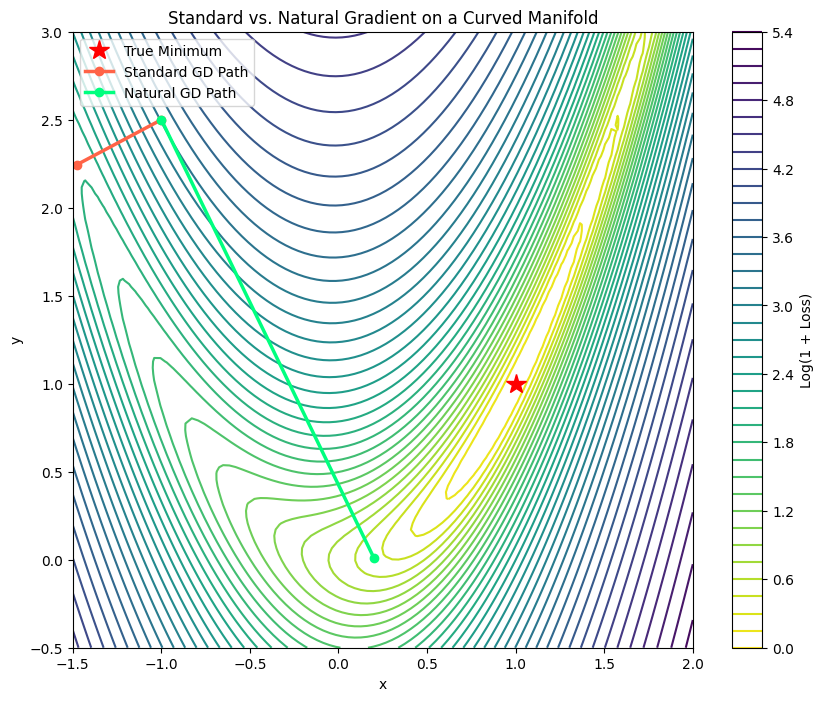

In [2]:
def loss_function(x, y):
    # The Rosenbrock function is a classic challenge for optimizers
    return (1 - x)**2 + 10 * (y - x**2)**2

x_range = np.linspace(-1.5, 2, 100)
y_range = np.linspace(-0.5, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = loss_function(X, Y)
Z_log = np.log(1 + Z)

def compute_euclidean_gradient(x, y):
    df_dx = -2 * (1 - x) - 40 * x * (y - x**2)
    df_dy = 20 * (y - x**2)
    return np.array([df_dx, df_dy])

grad_X, grad_Y = compute_euclidean_gradient(X, Y)

def get_fisher_metric_tensor(x, y):
    # A custom metric tensor that straightens the curved valley
    F11 = 1 + 400*x**2
    F12 = -200*x
    F21 = -200*x
    F22 = 100 * np.ones_like(x)
    F_grid = np.stack([[F11, F12], [F21, F22]], axis=0)
    return np.transpose(F_grid, (2, 3, 0, 1))

# The Natural Gradient field by inverting the metric at each point
F_grid = get_fisher_metric_tensor(X, Y)
natural_grad_X = np.zeros_like(grad_X)
natural_grad_Y = np.zeros_like(grad_Y)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        F_at_point = F_grid[i, j, :, :]
        F_inv_at_point = np.linalg.inv(F_at_point)
        grad_vec = np.array([grad_X[i, j], grad_Y[i, j]])
        natural_grad_vec = F_inv_at_point @ grad_vec
        natural_grad_X[i, j] = natural_grad_vec[0]
        natural_grad_Y[i, j] = natural_grad_vec[1]

# Animatation of the optimization paths for both algorithms
rc('animation', html='html5')
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contour(X, Y, Z_log, levels=35, cmap='viridis_r')
fig.colorbar(contour, ax=ax, label='Log(1 + Loss)')
ax.set_title("Standard vs. Natural Gradient on a Curved Manifold")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(1, 1, 'r*', markersize=15, label='True Minimum')

# NGD can use a much larger rate due to geometric correction
start_point = np.array([-1.0, 2.5])
lr_sgd = 0.0085
lr_ngd = 0.3
n_steps = 100000000000000
path_sgd = [start_point]
path_ngd = [start_point]

line_sgd, = ax.plot([], [], 'o-', color='tomato', lw=2.5, label='Standard GD Path')
line_ngd, = ax.plot([], [], 'o-', color='springgreen', lw=2.5, label='Natural GD Path')
ax.legend(loc='upper left')

def update(frame):
    current_pos_sgd = path_sgd[-1]
    grad_x_sgd = interpn((y_range, x_range), grad_X, current_pos_sgd[::-1], bounds_error=False, fill_value=0)[0]
    grad_y_sgd = interpn((y_range, x_range), grad_Y, current_pos_sgd[::-1], bounds_error=False, fill_value=0)[0]
    path_sgd.append(current_pos_sgd - lr_sgd * np.array([grad_x_sgd, grad_y_sgd]))

    current_pos_ngd = path_ngd[-1]
    natural_grad_x = interpn((y_range, x_range), natural_grad_X, current_pos_ngd[::-1], bounds_error=False, fill_value=0)[0]
    natural_grad_y = interpn((y_range, x_range), natural_grad_Y, current_pos_ngd[::-1], bounds_error=False, fill_value=0)[0]
    path_ngd.append(current_pos_ngd - lr_ngd * np.array([natural_grad_x, natural_grad_y]))

    line_sgd.set_data(np.array(path_sgd)[:, 0], np.array(path_sgd)[:, 1])
    line_ngd.set_data(np.array(path_ngd)[:, 0], np.array(path_ngd)[:, 1])
    return line_sgd, line_ngd

ani = FuncAnimation(fig, update, frames=200, blit=False, interval=30)

In [3]:
ani